<a href="https://colab.research.google.com/github/Ssurf777/VAEforPointCloud/blob/main/main_for_MoGVAE_v2_(MSE%2BCD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 43.7 MB/s eta 0:00:00


In [2]:
import requests
import os

def download_file(url, local_filename):
    """Downloads a file from a URL to a local file."""
    print(f"Downloading {url}...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=4096):  # Smaller chunk size
                    f.write(chunk)
        print(f"{local_filename} downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {local_filename}: {e}")

# URLs for downloading
urls = {
    "utils.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/utils.py",
    "file_io.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/file_io.py",
    "point_cloud.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/point_cloud.py",
    "sampling.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/sampling.py",
    "vae_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/vae_models.py",
    "ChamferDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ChamferDis.py",
    "EarthMoversDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/EarthMoversDis.py",
    "train.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/train.py",
    "visualize_loss.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/visualize_loss.py",
    "Dataloader.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/Dataloader.py",
    "mogvae_v2_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/mogvae_v2_models.py",
}

# Download each file
for local_filename, url in urls.items():
    download_file(url, local_filename)



utils.py downloaded successfully.
file_io.py downloaded successfully.
point_cloud.py downloaded successfully.
sampling.py downloaded successfully.
vae_models.py downloaded successfully.
ChamferDis.py downloaded successfully.
EarthMoversDis.py downloaded successfully.
train.py downloaded successfully.
visualize_loss.py downloaded successfully.
Dataloader.py downloaded successfully.
mogvae_v2_models.py downloaded successfully.


In [3]:

# Import downloaded modules
import utils
import file_io
import point_cloud
import sampling
import vae_models
import ChamferDis
import EarthMoversDis
import train
import Dataloader
import visualize_loss
import mogvae_v2_models
from utils import get_available_memory
from file_io import read_off
from point_cloud import pcshow
from sampling import PointSampler
from vae_models import standVAE
from ChamferDis import chamfer_distance
from EarthMoversDis import emd_distance
from train import train
from visualize_loss import visualize_loss
from Dataloader import prepare_data_for_ISAB
from mogvae_v2_models import MoGVAE

available_memory_gb = get_available_memory()
print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 11.27 GB


In [4]:
import torch
import torch.optim as optim
import numpy as np



device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_points =5000
# データ準備
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1, 10)]
data_loader = prepare_data_for_ISAB(file_names, num_points=num_points, device=device)
print(len(data_loader))

9


In [5]:

# ---------------- Training Loop ----------------

# ハイパーパラメータ設定
epochs = 5000
interval = 100

# モデル、オプティマイザ、デバイスなどの設定（例）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_points = 5000
n_z = 3  # 潜在次元
model = MoGVAE(num_points=5000, n_z=3, n_components=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
cd_error_record = []
rec_error_record = []
reg_error_record = []
total_error_record = []
z_list = []

for i in range(epochs):
    model.train()
    loss_rec = 0
    loss_cd = 0
    loss_reg = 0
    loss_total = 0

    for k, (x,) in enumerate(data_loader):
        #print(f"shape of x: {x.shape}")
        x = x.to(device)
        # バッチサイズが既にある場合、squeeze は不要です

        # VAEの出力と損失計算
        y, z = model(x)
        lrec, lcd, lreg = model.loss2(y, x)
        loss = 0.6 * lrec + 0.4 * lcd + lreg

        loss_cd += 0.4 * lcd.item()
        loss_rec += 0.6 * lrec.item()
        loss_reg += lreg.item()
        loss_total += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 最終エポックで z を収集
        if i == epochs - 1:
            z_list.append(z.cpu().detach().numpy())

    # 各エポックでの平均損失計算（バッチ数で割る）
    loss_rec /= (k + 1)
    loss_cd /= (k + 1)
    loss_reg /= (k + 1)
    loss_total /= (k + 1)

    rec_error_record.append(loss_rec)
    cd_error_record.append(loss_cd)
    reg_error_record.append(loss_reg)
    total_error_record.append(loss_total)

    if i % interval == 0:
        print(f"Epoch: {i} Loss_Rec: {loss_rec:.4f} Loss_CD: {loss_cd:.4f} Loss_Reg: {loss_reg:.4f} Loss_Total: {loss_total:.4f}")

# エポック終了後、z_list を保存
if len(z_list) > 0:
    z_array = np.array(z_list)
    np.save("z_list_final.npy", z_array)
    print(f"z_list saved with shape: {z_array.shape}")
else:
    print("Warning: z_list is empty. Nothing was saved.")


Epoch: 0 Loss_Rec: 5416.9859 Loss_CD: 0.2748 Loss_Reg: 55.7734 Loss_Total: 5473.0345
Epoch: 100 Loss_Rec: 716.6331 Loss_CD: 0.0894 Loss_Reg: 41.2521 Loss_Total: 757.9746
Epoch: 200 Loss_Rec: 695.0733 Loss_CD: 0.0869 Loss_Reg: 23.9392 Loss_Total: 719.0994
Epoch: 300 Loss_Rec: 688.0407 Loss_CD: 0.0840 Loss_Reg: 20.3264 Loss_Total: 708.4512
Epoch: 400 Loss_Rec: 624.3444 Loss_CD: 0.0761 Loss_Reg: 19.3224 Loss_Total: 643.7429
Epoch: 500 Loss_Rec: 536.3279 Loss_CD: 0.0665 Loss_Reg: 20.1557 Loss_Total: 556.5501
Epoch: 600 Loss_Rec: 452.3843 Loss_CD: 0.0540 Loss_Reg: 20.9425 Loss_Total: 473.3808
Epoch: 700 Loss_Rec: 385.3701 Loss_CD: 0.0474 Loss_Reg: 20.2883 Loss_Total: 405.7059
Epoch: 800 Loss_Rec: 275.7080 Loss_CD: 0.0397 Loss_Reg: 19.9302 Loss_Total: 295.6779
Epoch: 900 Loss_Rec: 200.7209 Loss_CD: 0.0365 Loss_Reg: 19.5958 Loss_Total: 220.3531
Epoch: 1000 Loss_Rec: 135.9947 Loss_CD: 0.0283 Loss_Reg: 19.1400 Loss_Total: 155.1630
Epoch: 1100 Loss_Rec: 91.1018 Loss_CD: 0.0246 Loss_Reg: 18.3580 

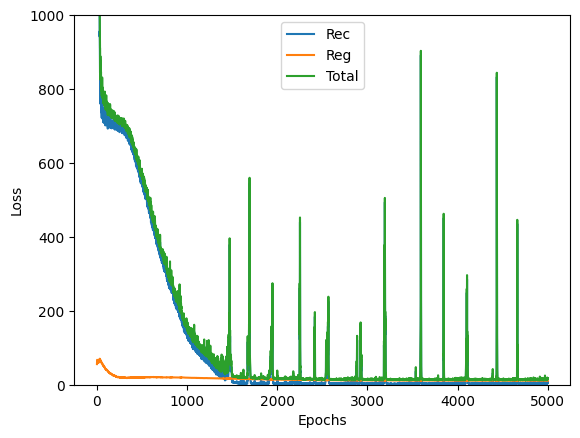

Model weights have been saved!


In [6]:
# 損失の可視化
visualize_loss(rec_error_record, reg_error_record, total_error_record)

# モデル保存
torch.save(model.state_dict(), '/content/drive/MyDrive/chair/MoGVAE_Np5000_MSE+CD2_0224.pth')
print("Model weights have been saved!")

In [7]:
print(z_list) # z mu logvar

[array([[ 0.7699041, -0.3477257, -2.233336 ]], dtype=float32), array([[ 2.066025  ,  0.82424486, -0.641272  ]], dtype=float32), array([[ 0.8891246, -1.4089671, -1.5974469]], dtype=float32), array([[ 1.7636385, -0.3633805, -1.1275631]], dtype=float32), array([[ 1.4129614 , -0.80768555, -1.4065397 ]], dtype=float32), array([[ 1.7393771 , -1.115827  ,  0.02783974]], dtype=float32), array([[ 1.227615  , -2.0905874 , -0.85848725]], dtype=float32), array([[ 1.1684227,  0.8985593, -1.9365877]], dtype=float32), array([[ 1.5953118 , -1.5649191 , -0.47855824]], dtype=float32)]


# 再構成形状の可視化

torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])


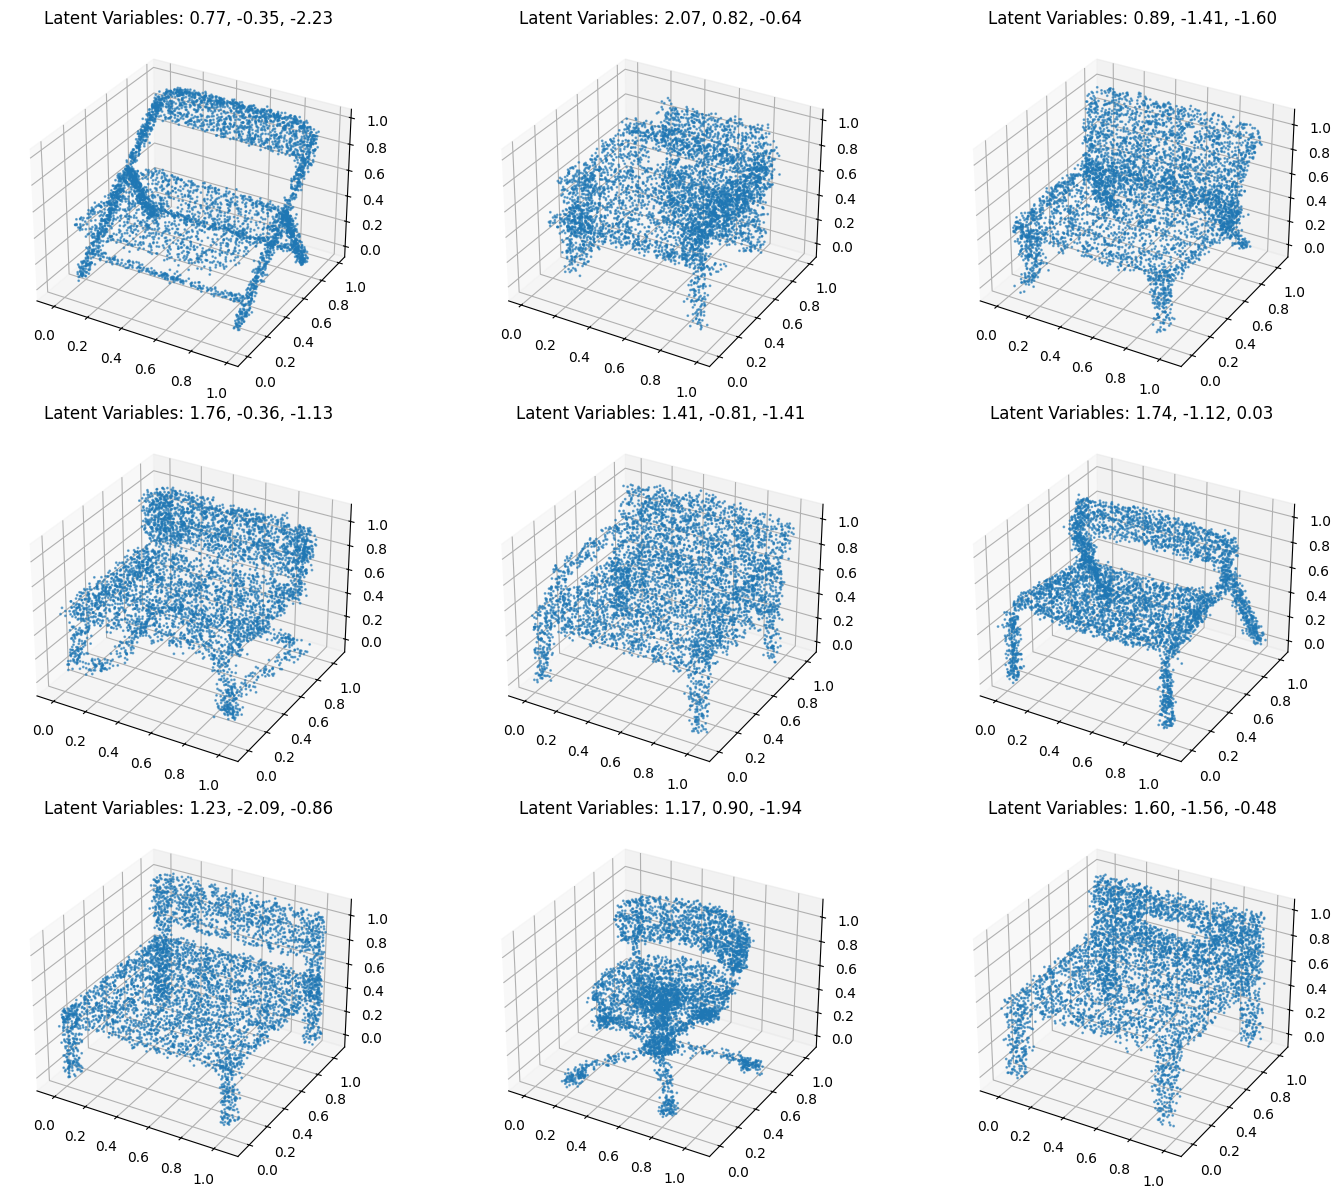

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# z_list_final.npy を読み込んで z_list に変換
z_array = np.load("z_list_final.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_list = [torch.tensor(z_array[i], dtype=torch.float32).to(device) for i in range(z_array.shape[0])]

# 可視化用設定
num_points = 5000
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# 再構成と可視化
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    recon_batch = model.decode(z)  # z をバッチの形状に変換
    print(recon_batch.shape)

    # CPU上で detach して numpy に変換
    # デコード結果 recon_batch: (1, num_points, 3)
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得
    reconst_x = reconst_np[:, 0]
    reconst_y = reconst_np[:, 1]
    reconst_z = reconst_np[:, 2]

    # プロット
    axes[index].scatter(reconst_x, reconst_y, reconst_z, s=1, alpha=0.6)

    # 潜在変数の値をフラット化してタイトルに表示
    z_flat = z.view(-1).tolist()  # 1次元化
    z_str = ", ".join([f"{value:.2f}" for value in z_flat])
    axes[index].set_title(f"Latent Variables: {z_str}")

# 最後にプロットを表示
plt.tight_layout()
plt.show()


# 再構成誤差チェック using CD

Chamfer Distances: [0.03425195813179016, 0.03694738447666168, 0.03541877120733261, 0.03748694807291031, 0.037008270621299744, 0.026927988976240158, 0.04003925994038582, 0.04138340801000595, 0.041042789816856384]
Average Chamfer Distance: 0.0367229754726092


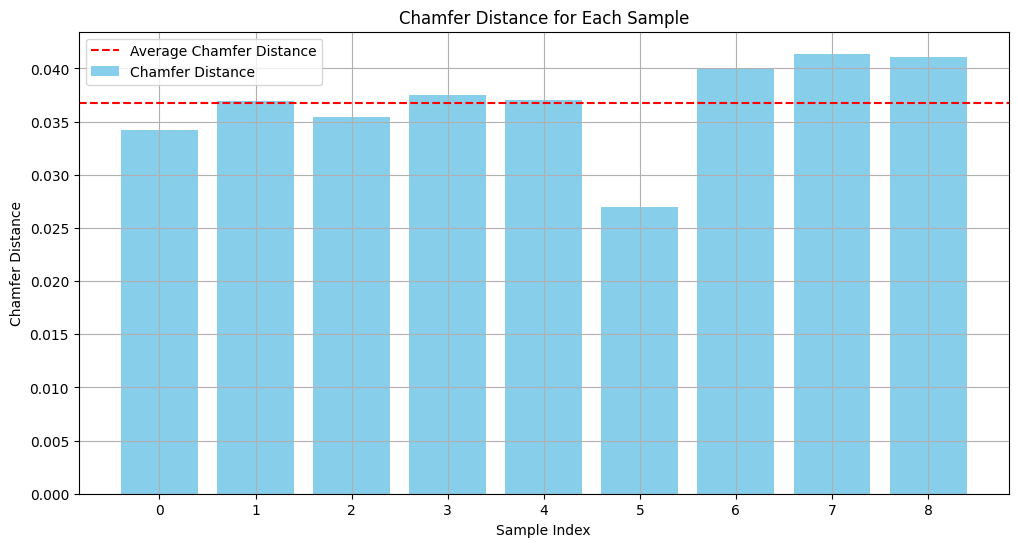

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
reconstructed_point_cloud=[]
# Chamfer Distanceの計算
chamfer_distances = []
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = model.decode(z_list[i])
    # CPU上で detach して numpy に変換
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得し、Tensor に変換
    reconst_x = torch.from_numpy(reconst_np[:, 0])
    reconst_y = torch.from_numpy(reconst_np[:, 1])
    reconst_z = torch.from_numpy(reconst_np[:, 2])

    # Tensor を stack して reconstructed_point_cloud を作成
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)


    # 元の点群の形状を整える
    original_point_cloud = x.reshape(1, num_points, 3).to(device)

    # カスタム関数でChamfer Distanceを計算
    loss_cd = chamfer_distance(original_point_cloud, reconstructed_point_cloud)
    chamfer_distances.append(loss_cd.item())

# Chamfer距離を出力
print("Chamfer Distances:", chamfer_distances)
average_chamfer_distance = sum(chamfer_distances) / len(chamfer_distances)
print(f"Average Chamfer Distance: {average_chamfer_distance}")

import matplotlib.pyplot as plt

# Chamfer Distancesの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(chamfer_distances)), chamfer_distances, color='skyblue', label='Chamfer Distance')
plt.axhline(y=average_chamfer_distance, color='r', linestyle='--', label='Average Chamfer Distance')

# グラフの装飾
plt.title('Chamfer Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Chamfer Distance')
plt.xticks(range(len(chamfer_distances)))
plt.legend()
plt.grid(True)
plt.show()


# 再構成誤差チェック using EMD

/usr/local/lib/python3.11/dist-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


EMD Distances: [0.03700016587464662, 0.029644702523108524, 0.0259767745614331, 0.024649348907299817, 0.028165119640269395, 0.019660443394175213, 0.032258843082356, 0.041766873075613754, 0.03255651054681941]
Average EMD Distance: 0.03018653128952465


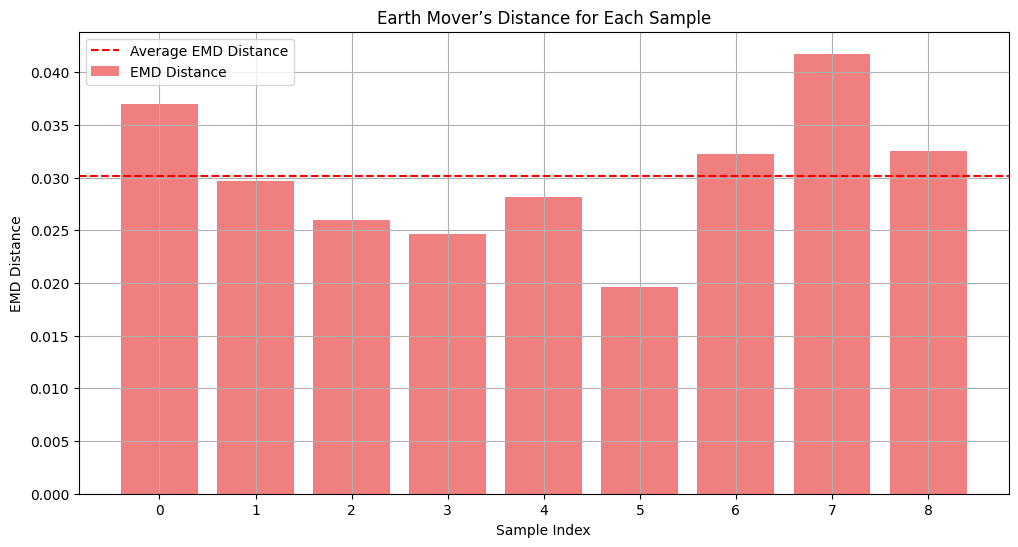

In [10]:
import torch
import ot  # Optimal Transportライブラリ
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# EMDの計算
emd_distances = []
reconstructed_point_cloud=[]
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = model.decode(z_list[i])
    # CPU上で detach して numpy に変換
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得し、Tensor に変換
    reconst_x = torch.from_numpy(reconst_np[:, 0])
    reconst_y = torch.from_numpy(reconst_np[:, 1])
    reconst_z = torch.from_numpy(reconst_np[:, 2])

    # Tensor を stack して reconstructed_point_cloud を作成
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)
    reconstructed_point_cloud = reconstructed_point_cloud.reshape(num_points, 3).to(device)


    # 元の点群の形状を整える
    original_point_cloud = x.reshape(num_points, 3).to(device)

    # カスタム関数でEMDを計算
    loss_emd = emd_distance(original_point_cloud, reconstructed_point_cloud)
    emd_distances.append(loss_emd)

# EMDの結果を出力
print("EMD Distances:", emd_distances)
average_emd_distance = sum(emd_distances) / len(emd_distances)
print(f"Average EMD Distance: {average_emd_distance}")

# EMDの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(emd_distances)), emd_distances, color='lightcoral', label='EMD Distance')
plt.axhline(y=average_emd_distance, color='r', linestyle='--', label='Average EMD Distance')

# グラフの装飾
plt.title('Earth Mover’s Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('EMD Distance')
plt.xticks(range(len(emd_distances)))
plt.legend()
plt.grid(True)
plt.show()
